In [1]:
import numpy as np
import os
import sys

import torch
from torch import nn

import matplotlib.pyplot as plt
from IPython import display

from pipnet import data
from pipnet import model

np.random.seed(1)

In [2]:
def plot_X(X, y, figsize=(16,6), n_row=2, n_col=3, n_show=4, file=None):
    
    fig = plt.figure(figsize=figsize)
    axs = []
    for i in range(n_row):
        for j in range(n_col):
            axs.append(fig.add_subplot(n_row, n_col, (i * n_col) + j + 1))

    for i in range(n_show):
        if X.dim() == 4:
            axs[i].plot(X[i, :, 0, :].T)
        else:
            axs[i].plot(X[i].T)
        if y is not None:
            axs[i].plot(y[i, 0], "r")
        
    fig.tight_layout()
    
    if file is not None:
        plt.savefig(file)
    
    plt.show()
    plt.close()
    
    return

In [3]:
def live_plot_nb(y_out, y_trg, step, n_steps, loss, lr, figsize=(16,6), n_row=1, n_col=2, n_show=2, show_loss=True, log=False, file=None):
    
    display.clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    axs = []
    for i in range(n_row):
        for j in range(n_col):
            axs.append(fig.add_subplot(n_row, n_col, (i * n_col) + j + 1))

    for i in range(n_show):
        axs[i].plot(y_trg[i, -1])
        axs[i].plot(y_out[i, -1])

    if show_loss:
        axs[i+1].plot(loss)
        axs[i+1].plot(np.argmin(loss), np.min(loss), "ro")
        axs[i+2].plot(lrs)
    
    if log:
        axs[i+1].set_xscale("log")
        axs[i+1].set_yscale("log")
        axs[i+2].set_xscale("log")
        axs[i+2].set_yscale("log")
    
    fig.tight_layout()
    
    if file is not None:
        plt.savefig(file)
    
    plt.show()
    plt.close()
    
    return

# Define data generation parameters

In [4]:
iso_pars = dict(
    td = 512,
    Fs = 12_800,
    nmin = 1,
    nmax = 15,
    freq_range = [2_000., 10_000.],
    gmin = 1,
    gmax = 1,
    spread = 5.,
    lw_range = [[5e1, 2e2], [1e2, 5e2], [1e2, 1e3]],
    lw_probs = [0.7, 0.2, 0.1],
    int_range = [0.5, 1.], # Intensity
    phase = 0.,
    debug = False,
)

mas_pars = dict(
    nw = 8,
    mas_w_range = [30_000., 100_000.],
    random_mas = False,
    mas_phase_p = 0.5,
    mas_phase_scale = 0.05,
    
    # First-order MAS-dependent parameters
    mas1_lw_range = [[1e7, 5e7], [5e7, 1e8]],
    mas1_lw_probs = [0.8, 0.2],
    mas1_m_range = [[0., 0.], [0., 1e4], [1e4, 5e4]],
    mas1_m_probs = [1., 0.1, 0.8],
    mas1_s_range = [[-1e7, 1e7]],
    mas1_s_probs = [1.],

    # Second-order MAS-dependent parameters
    mas2_prob = 1.,
    mas2_lw_range = [[0., 0.], [1e11, 5e11]],
    mas2_lw_probs = [0.2, 0.8],
    mas2_m_range = [[0., 0.], [1e8, 5e8]],
    mas2_m_probs = [0.9, 0.1],
    mas2_s_range = [[0., 0.], [-2e10, 2e10]],
    mas2_s_probs = [0.8, 0.2],
    
    # Other MAS-dependent parameters
    non_mas_p = 0.5,
    non_mas_m_trends = ["constant", "increase", "decrease"],
    non_mas_m_probs = [0.34, 0.33, 0.33],
    non_mas_m_range = [0., 1.],
    
    int_decrease_p = 0.1,
    int_decrease_scale =[0.3, 0.7],
    debug = False,
)

data_pars = dict(
    iso_pars = iso_pars,
    mas_pars = mas_pars,
    
    positive_iso = True,
    encode_imag = False, # Encode the imaginary part of the MAS spectra
    encode_wr = True, # Encode the MAS rate of the spectra

    # noise parameters
    noise = 0., # Noise level
    mas_l_noise = 0.05,
    mas_s_noise = 25.,
    
    smooth_end_len = 10, # Smooth ends of spectra
    iso_spec_norm = 256., # Normalization factor for peaks
    mas_spec_norm = 64., # Normalization factor for MAS spectra
    wr_norm_factor = 100_000.,
    wr_inv = False, # Encode inverse of MAS rate instead of MAS rate
    gen_mas_shifts = True,
)

model_pars = dict(
    input_dim = 2,
    n_models = 1,
    hidden_dim = [64, 64],
    kernel_size = [5, 5],
    num_layers = 2,
    batch_input = 6,
    bias = True,
    output_bias = True,
    return_all_layers = True,
    batch_norm = False,
    ndim = 1,
    independent = True,
    output_kernel_size = 5,
    output_act = "sigmoid",
    noise = 0.,
    invert = False,
)

loss_pars = dict(
    trg_fuzz=3.,
    trg_fuzz_len=25,
    ndim=1,
    exp=1.0,
    offset=1.0,
    factor=100.0,
    int_w=0.0,
    int_exp=2.0,
    return_components=False,
    device="cpu",
)

fig_dir = "../../figures/1D/sanity_check/"
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [5]:
dataset = data.Dataset(**data_pars)

# Get training data (4 samples)

In [6]:
n_samples = 4
X = []
P = []
y = []

for i in range(n_samples):
    xi, pi, yi = dataset.__getitem__(i)
    X.append(torch.unsqueeze(xi, 0))
    y.append(torch.unsqueeze(yi, 0))
    P.append(torch.unsqueeze(pi, 0))

X = torch.cat(X)
y = torch.cat(y)
P = torch.cat(P)

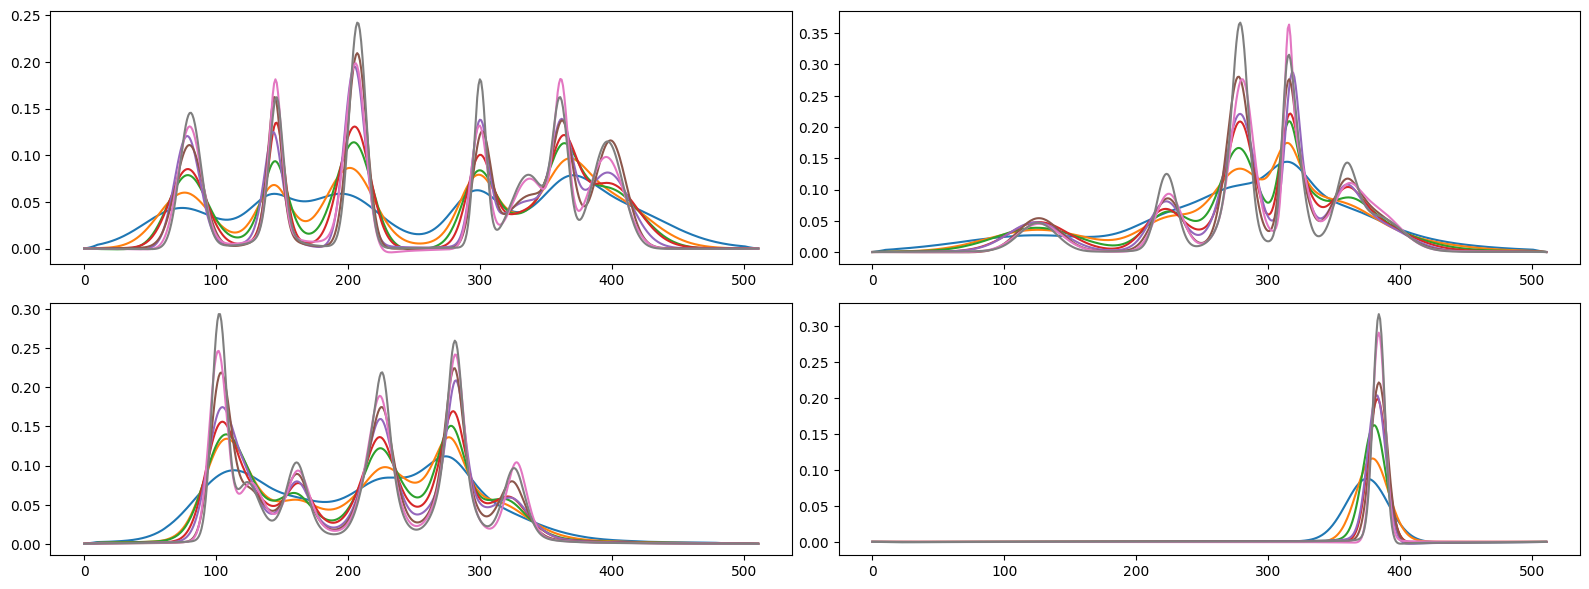

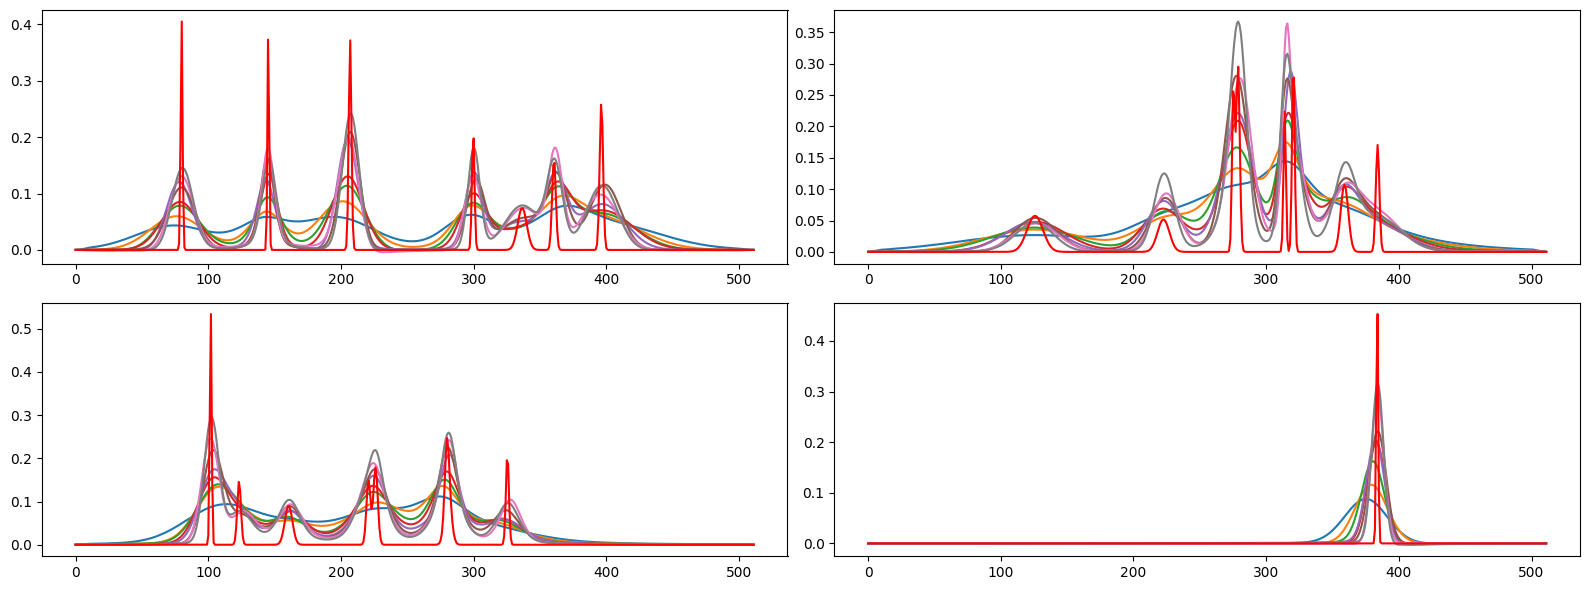

In [7]:
plot_X(X, None, n_row=2, n_col=2, n_show=4, file=fig_dir + "inputs.pdf")
plot_X(X, y, n_row=2, n_col=2, n_show=4, file=fig_dir + "inputs_with_trg.pdf")

# Define network, loss and optimizer

In [8]:
net = model.ConvLSTMEnsemble(**model_pars)
L = model.PIPLoss(**loss_pars)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=50)

# Train the model

In [ ]:
net.

KeyboardInterrupt: 

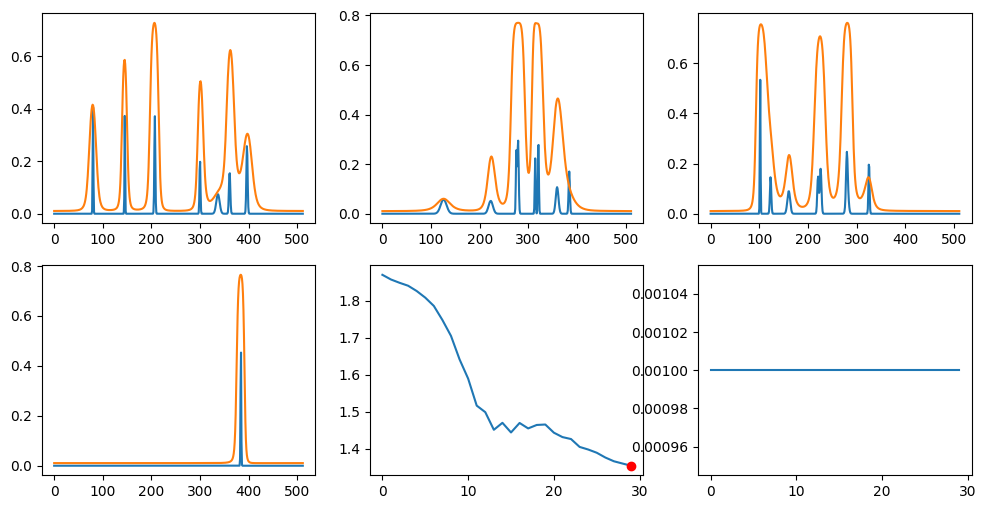

In [9]:
n_train = 100

net.train()

ymax = torch.max(y)

losses = []
lrs = []

for i in range(n_train):
    
    print("{}/{}".format(i+1, n_train))
    
    net.zero_grad()
    
    output, _, _ = net(X)
    
    y_trg = y.repeat(1, output.shape[1], 1)
    
    loss = L(output, y_trg)
    
    loss.backward()
    
    losses.append(float(loss.detach()))
    
    opt.step()
    
    sch.step(loss)
    
    lrs.append(opt.param_groups[0]["lr"])
    live_plot_nb(output.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4)